In [2]:
import os
import json

import numpy as np
import sympy as sym 
import pandas as pd

import scipy.integrate
import matplotlib.pyplot as plt

from itertools import permutations

The following notebook includes code to:
- i. Generate a combinatorial set of networks.
- ii. Use experimental biophysical measurements to parameterize networks.
- iii. Prune networks to arrive at a single reaction network consistent with available data. 

Finally, this notebook includes code for simulating depletions and generating configuratoin files for lattice and polymer simulations.


# Five state models

## Combinatorial network generation


We use the following notation for chemical species:

- "RB": 'bare' bound cohesin, "R" free cohesin
- "RN":  bound cohesin co-bound with NIPBL, "N" free NIPBL
- "RP":  bound cohesin co-bound with PDS5, "P" free PDS5
- "RW":  bound cohesin co-bound with WAPL, "W" free WAPL

This enables convenient enumeration of possible chemical reaction networks. 

The following code creates all possible circular reaction networks starting from the unbound "R" state and any possible permutation of the four bound states (RB, RN, RP, RW). Networks are specified as a list of transitions.

In [3]:
## Enumerate state sequences and associated transitions
bound_states = ['RB', 'RN', 'RP', 'RW']
full_states = bound_states + ['R', 'N', 'P', 'W']

transitions_list = []
sequence_list = list(permutations(bound_states))

state_ids = {k: v for v, k in enumerate(full_states)}
state_symbols = {k: sym.symbols(k) for k in full_states}

for sequence in sequence_list:
    transitions = [('R', sequence[0])]

    for s1, s2 in zip(sequence[:-1], sequence[1:]):
        transitions.append((s1, s2))
        transitions.append((s2, s1))

    transitions.append((sequence[-1], 'R'))
    transitions_list.append(transitions)

For each sequence of transitions, the following code uses mass action to generate the right-hand side (rhs) of the equation specifying how each state evolves over time.

In [4]:
## Work out dynamical equations
rhs_list = []
rate_symbols_list = []

for transitions in transitions_list:
    rhs = sym.zeros(len(state_symbols), 1)
    rate_symbols = {(s1, s2): sym.symbols(f"k_{s1[-1]}{s2[-1]}") for s1, s2 in transitions}

    for s1, s2 in transitions:        
        if s2[-1] not in ['R', 'B']:
            rhs[state_ids[s1]] -= rate_symbols[(s1, s2)] * state_symbols[s1] * state_symbols[s2[-1]]
            rhs[state_ids[s2]] += rate_symbols[(s1, s2)] * state_symbols[s1] * state_symbols[s2[-1]]

        else:
            rhs[state_ids[s1]] -= rate_symbols[(s1, s2)] * state_symbols[s1]
            rhs[state_ids[s2]] += rate_symbols[(s1, s2)] * state_symbols[s1]

    rhs[state_ids['N']] = -rhs[state_ids['RN']]
    rhs[state_ids['P']] = -rhs[state_ids['RP']]
    rhs[state_ids['W']] = -rhs[state_ids['RW']]

    rhs_list.append(rhs)
    rate_symbols_list.append(rate_symbols)


## Parameter inference

In [5]:
biophys_df = pd.read_csv('../data/biophysical_params_HeLa.csv', comment='#')#, delimiter=',')#,quotechar='"')

parameter_dict_wt = dict(zip(biophys_df['parameter'].values, biophys_df['value'].values))

Curated biophysical measurements include the residence time, bound fraction, and abundance of each of RAD21, NIPBL, PDS5, and WAPL.

Since transition rates between states are not directly determined experimentally, the following code inverts the set of equations using the known measurements to determine transition rates. 

In [14]:
## Set parameters and variables
parameters = sym.symbols(list(parameter_dict_wt.keys()))
tau_N, F_N, N_N, tau_P, F_P, N_P, tau_W, F_W, N_W, tau_R, F_R, N_R = parameters

variables = state_symbols.values()
RB, RN, RP, RW, R, N, P, W = variables

Under the assumption of mutally exclusive co-binding of regulators, the amount of 'bare' bound RAD21 is the total amount of bound RAD21 minus the bound amounts of NIPBL, PDS5, and WAPL. 

In [7]:
## Set substitution dictionaries for equilibrium concentrations
subs_dict = {'RB': N_R * F_R - N_N * F_N - N_P * F_P - N_W * F_W,
             'RN': N_N * F_N,
             'RP': N_P * F_P,
             'RW': N_W * F_W,
             'R': N_R * (1 - F_R),   
             'N': N_N * (1 - F_N),
             'P': N_P * (1 - F_P),
             'W': N_W * (1 - F_W)}

subs_R = {k: v for k, v in subs_dict.items() if k not in ['R']}
subs_N = {k: v for k, v in subs_dict.items() if k not in ['N', 'RN']}
subs_P = {k: v for k, v in subs_dict.items() if k not in ['P', 'RP']}
subs_W = {k: v for k, v in subs_dict.items() if k not in ['W', 'RW']}

In [8]:
## Map cohesin transition rates to PDS5/WAPL/NIPBL/PDS5 measurements
rate_dict_list = []

for i, rhs in enumerate(rhs_list):
    rate_dict = {}

    rate_symbols = rate_symbols_list[i]
    rhs_eq = sym.zeros(len(rate_symbols), 1)

    eq_R = rhs[state_ids['R']].subs(subs_R)
    eq_N = rhs[state_ids['N']].subs(subs_N)
    eq_P = rhs[state_ids['P']].subs(subs_P)
    eq_W = rhs[state_ids['W']].subs(subs_W)

    # Equilibrium subunit bound fractions
    rhs_eq[state_ids['R']] = sym.collect(eq_R, R).coeff(R, 1) + 1/tau_R * F_R / (1-F_R)
    rhs_eq[state_ids['N']] = sym.collect(eq_N, N).coeff(N, 1) + 1/tau_N * F_N / (1-F_N)
    rhs_eq[state_ids['P']] = sym.collect(eq_P, P).coeff(P, 1) + 1/tau_P * F_P / (1-F_P)
    rhs_eq[state_ids['W']] = sym.collect(eq_W, W).coeff(W, 1) + 1/tau_W * F_W / (1-F_W)

    # Equilibrium subunit residence times
    rhs_eq[state_ids['RB']] = sym.collect(eq_R, R).coeff(R, 0) - N_R*F_R/tau_R
    rhs_eq[state_ids['RN']] = sym.collect(eq_N, RN).coeff(RN, 1) - 1/tau_N
    rhs_eq[state_ids['RP']] = sym.collect(eq_P, RP).coeff(RP, 1) - 1/tau_P
    rhs_eq[state_ids['RW']] = sym.collect(eq_W, RW).coeff(RW, 1) - 1/tau_W

    sol_rates = sym.solve(rhs_eq, *rate_symbols.values())

    for rate, expr in sol_rates.items():
        value = expr.evalf(subs=parameter_dict_wt)
        rate_dict[str(rate)] = value

    rate_dict_list.append(rate_dict)


In [9]:
# Enumerate all models with physical kinetics (i.e. positive rates)
candidate_list = []

for sequence, rate_dict in zip(sequence_list, rate_dict_list):
    has_physical_kinetics = all(value > 0 for value in rate_dict.values())
            
    if has_physical_kinetics:
        candidate_list.append(sequence)

print(candidate_list)

[('RB', 'RP', 'RN', 'RW'), ('RN', 'RB', 'RP', 'RW'), ('RN', 'RP', 'RB', 'RW'), ('RP', 'RB', 'RN', 'RW'), ('RW', 'RB', 'RP', 'RN'), ('RW', 'RN', 'RB', 'RP'), ('RW', 'RN', 'RP', 'RB'), ('RW', 'RP', 'RB', 'RN')]


## Time integration

In [10]:
## Set initial state and integration time interval
init_state = sym.Matrix([[0, 0, 0, 0, # Starting from completely unbound population of RAD21
                          N_R, N_N, N_P, N_W]]) # Degrons can now be simulated by updating protein levels directly from init_state

t = sym.symbols('t') 
t_eval = np.linspace(0, 60 * 600, 10000) # evaluate integral from t = 0-600 minutes for 10000 points

tspan = (t_eval[0], t_eval[-1])

In [11]:
# Integrate coupled mass action equations
def solve_kinetics(rhs, rate_dict, parameter_dict):
    rhs_eval = list(rhs.evalf(subs=rate_dict))
    y0 = list(init_state.evalf(subs=parameter_dict))

    f = sym.lambdify((t, variables), rhs_eval)

    solution = scipy.integrate.solve_ivp(f, tspan, y0, t_eval=t_eval)

    return solution.y

In [12]:
# Get change in bound fraction of a given species
def relative_bound(species, parameter_dict_wt, parameter_dict_mut, final_state_wt, final_state_mut):                
    if species in state_symbols:
        abundance_key = f"N_{species}"

        wt_bound = parameter_dict_wt[abundance_key] - final_state_wt[state_ids[species]]
        mut_bound = parameter_dict_mut[abundance_key] - final_state_mut[state_ids[species]]

        return mut_bound / wt_bound
    
    else:
        raise ValueError('Perturbation consequence not in known state symbols')

In [13]:
# pertubation = [perturb_param, perturb_ratio, conditions={species:relative_bound_ratio}]
perturbations = [
    ['N_W', 1/5, {'R':'>1'}], #F_R goes up in dWAPL: Wutz2017 Fig4F 
    ['N_P', 1/5, {'R':'>1'}],  #F_R goes up in dPDS5: Wutz2017 Fig4F
    ['N_N', 1/5, {'R':'<1'}],  #F_R goes down in dNIPBL: Haarhuis2017 Fig4E
]

In [17]:
verbose = True

# Enumerate all models satisfying experimental constraints
for sequence, rhs, rate_dict in zip(sequence_list, rhs_list, rate_dict_list):
    if sequence in candidate_list:
        final_state_wt = solve_kinetics(rhs, rate_dict, parameter_dict_wt)[:,-1]
        check_list = []

        for perturbation in perturbations:
            perturbation_param, perturbation_ratio, consequences = perturbation
            
            parameter_dict_mut = parameter_dict_wt.copy()
            parameter_dict_mut[perturbation_param] *= perturbation_ratio

            final_state_mut = solve_kinetics(rhs, rate_dict, parameter_dict_mut)[:,-1]

            for species, value in consequences.items():
                ratio = relative_bound(species, parameter_dict_wt, parameter_dict_mut, final_state_wt, final_state_mut)                
                check_list.append(eval(f"{ratio}{value}"))
        
        if verbose: 
            print(check_list)

        if not np.array(check_list).all():
            candidate_list.remove(sequence)

print(candidate_list)

[True, True, True]
[('RN', 'RB', 'RP', 'RW')]


In [27]:
# we designate the one remaining candidate as the "Five state sequence"
five_state_sequence = candidate_list[0]
sequence = five_state_sequence
sequence_index = sequence_list.index(five_state_sequence)
five_state_rhs = rhs_list[sequence_index]
five_state_rate_dict = rate_dict_list[sequence_index]

solution = solve_kinetics(five_state_rhs, five_state_rate_dict, parameter_dict_wt)


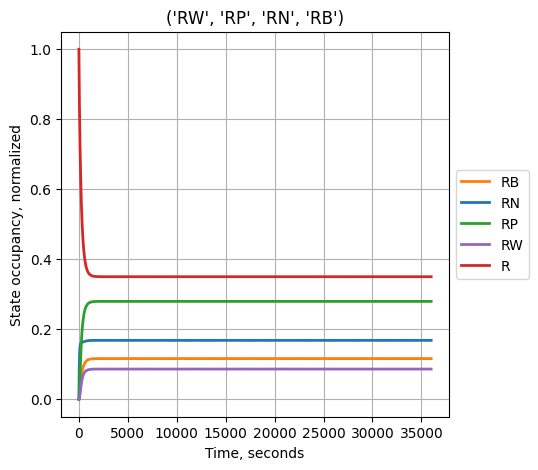

In [ ]:
figwidth = 5
fig = plt.figure(figsize=(figwidth, figwidth)) 
ax = plt.subplot(1,1,1)

ax.set_prop_cycle('color', ['#ff7f0e', '#1f77b4', '#2ca02c', '#9467bd', '#d62728'])
plt.plot(t_eval, solution[:5].T / parameter_dict_wt['N_R'], lw=2) 
ax.legend(list(variables)[:5], shadow=False,
            loc='center left', bbox_to_anchor=(1, 0.5))

plt.title(sequence)
plt.grid(True)

_ = plt.xlabel('Time, seconds')
_ = plt.ylabel('State occupancy, normalized')

save_trajectory = False
if save_trajectory:
    sequence_string = "_".join(sequence)
    output_kin_path = f"../data/state_kinetics_HeLa_{sequence_string}.res"
    ordered_solution = solution[np.argsort(list(sequence) + ['R'])]
    np.savetxt(output_kin_path, np.r_[t_eval[None,:], ordered_solution].T)

In [31]:
variable_list = list(map(str, variables))

In [37]:
def create_extrusion_dict(reference_dict, sequence, rhs, rate_dict, parameter_dict, update_velocity=False, types=['A']):
    solution = solve_kinetics(rhs, rate_dict, parameter_dict)
    final_state = solution[:,-1]

    extrusion_dict = reference_dict.copy()
    extrusion_dict["LEF_states"] = {k: v+1 for v, k in enumerate(sequence)}

    for rate, value in rate_dict.items():
        s1 = f"R{rate[-2]}"
        s2 = f"R{rate[-1]}"

        id1 = sequence.index(s1)+1 if s1 in sequence else 0
        id2 = sequence.index(s2)+1 if s2 in sequence else 0

        rate_key = f"{id1}{id2}"
    
        if rate[-1] not in ['R', 'B']:
            k = variable_list.index(rate[-1])
            value *= final_state[k]

        if (id1 != 0) & (id2 != 0):
            extrusion_dict["LEF_transition_rates"][rate_key] = {t: float(value) for t in types}
        elif id1 == 0:
            extrusion_dict["LEF_on_rate"] = {t: float(value) for t in types}
        elif id2 == 0:
            extrusion_dict["LEF_off_rate"] = {t: float(value) for t in types}
            extrusion_dict["LEF_stalled_off_rate"] = {t: float(value) for t in types}

    # Update velocity multiplier based on equilibrium proportion of active extruders so that average extrusion velocity remains unchanged
    # Note that this assumes that the reference dict corresponds to a two-state extruder with constant extrusion velocity
    if update_velocity:    
        active_index = variable_list.index('RN')
        rescale_velocity = parameter_dict['F_R'] * parameter_dict['N_R'] / final_state[active_index]

        extrusion_dict["velocity_multiplier"] *= rescale_velocity

    return extrusion_dict

In [38]:
# modify an extrusion dictionary for 2-state model with average velocity 1kb/sec
# to generate an extrusion dictioanry for the five-state model and the same average velocity 
with open("../data/extrusion_dict_HeLa_twostate.json", 'r') as dict_file:
    reference_dict = json.load(dict_file) 

extrusion_dict = create_extrusion_dict(reference_dict, 
                                       five_state_sequence, 
                                       five_state_rhs, 
                                       five_state_rate_dict, 
                                       parameter_dict_wt.copy(), 
                                       update_velocity=True)

sequence_string = "_".join(sequence)
output_dict_path = f"../data/extrusion_dict_HeLa_{sequence_string}.json"

with open(output_dict_path, 'w') as output_dict_file:
    json.dump(extrusion_dict, output_dict_file, indent=4)


In [39]:
# Simulate WAPL depletion by reducing the number of WAPL by 5-fold

parameter_dict_dWAPL = parameter_dict_wt.copy()
parameter_dict_dWAPL['N_W'] /= 5

solution_wt = solve_kinetics(five_state_rhs, five_state_rate_dict, parameter_dict_wt)
solution_dWAPL = solve_kinetics(five_state_rhs, five_state_rate_dict, parameter_dict_dWAPL)


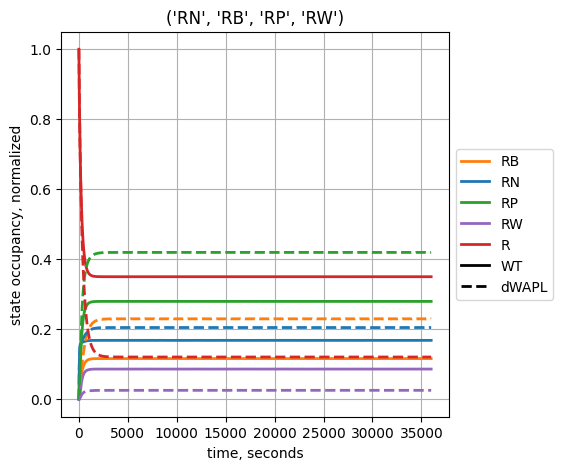

In [40]:

fig = plt.figure(figsize=(figwidth, figwidth)) 
ax = plt.subplot(1,1,1)

ax.set_prop_cycle('color', ['#ff7f0e', '#1f77b4', '#2ca02c', '#9467bd', '#d62728'])

plt.plot(t_eval, solution_wt[:5].T / parameter_dict_wt['N_R'], lw=2) 

plt.plot([], [], 'k', lw=2) 
plt.plot([], [], 'k--', lw=2) 

plt.plot(t_eval, solution_dWAPL[:5].T / parameter_dict_dWAPL['N_R'], ls='--', lw=2) 

ax.legend(list(variables)[:5]+['WT', 'dWAPL'], shadow=False,
            loc='center left', bbox_to_anchor=(1, 0.5))

plt.title(sequence)

plt.grid(True)

_ = plt.xlabel('time, seconds')
_ = plt.ylabel('state occupancy, normalized')


In [41]:
# Generate mutant dictionaries across multiple depletion levels
parameter = 'N_W'
depletion_levels = np.linspace(0.1, 1, num=10)

sequence = five_state_sequence
rhs = five_state_rhs
rate_dict = five_state_rate_dict
sequence_string = "_".join(sequence)

out_dir = f"../data/{parameter}"
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

with open(f"../data/extrusion_dict_HeLa_{sequence_string}.json", 'r') as dict_file:
    reference_dict = json.load(dict_file) 
    
for level in depletion_levels:
    parameter_dict = parameter_dict_wt.copy()
    parameter_dict[parameter] *= level

    extrusion_dict = create_extrusion_dict(reference_dict, 
                                           sequence, 
                                           rhs, 
                                           rate_dict, 
                                           parameter_dict)

    output_dict_path = f"{out_dir}/extrusion_dict_HeLa_{sequence_string}_{level:.2f}.json"

    with open(output_dict_path, 'w') as output_dict_file:
        json.dump(extrusion_dict, output_dict_file, indent=4)